In [2]:
import wrf
import cftime
import math
from wrf import getvar, ALL_TIMES, latlon_coords
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import datetime
from datetime import datetime, timedelta
# import nc_time_axis
# from cftime import DatetimeNoLeap
import numpy as np
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
import glob
from braceexpand import braceexpand
import os
import pandas as pd
import time
%matplotlib inline
%config InlineBackend.figure_format='retina'


### Functions

In [3]:
# Purpose: To alliviate the memory issue that arrises when you getvar() a big dataset.
# Input:
    # xrDataset = xr.open_dataset(filepath)
    # Dataset = Dataset(filepath)
    # varname = '<variablename>'
# Output:
    # da: This will be the xr.DataArray you are after
# Process:
    # First create an empty np.array that holds varname values.
    # Loop through each timestep to fill in the np.array.
    # Here's the trick, only getvar() one timestep, then expand the time dim.
        # This will repeate the values from the first timestep into the Time dim.
    # Assign the Time coordinates.
    # Replace the repeated values with the correct values from npArray.

# This method is ~6x more efficient than getvar(Dataset, varname, ALL_TIMES)

def wrf_np2da(xrDataset,Dataset,varname):
    da_times = getvar(Dataset, 'times', ALL_TIMES)			# Times in datetime64
    # Create empty numpy array
    npArray = np.empty((xrDataset.dims['Time'],xrDataset.dims['bottom_top'],
                        xrDataset.dims['south_north'],xrDataset.dims['west_east']),np.float32)
    for i in range(npArray.shape[0]):
        npArray[i,...] = getvar(Dataset, varname, timeidx=i, meta=False)
    da = getvar(Dataset, varname, timeidx=0)
    da = da.expand_dims(dim={'Time': da_times}, axis=0)
    da = da.assign_coords(dict(
        Time=('Time',da_times.values),
        XTIME=('Time',np.float32(xrDataset['ITIMESTEP'].values))
    ))
    da.values = npArray
    return da

In [4]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.

def assign_LT_coord(da):
	hour_offset = (da.XLONG.values[:,0,:]/15).round(decimals=0)
	local_time = np.empty([len(da.Time),len(da.west_east)], dtype=object)
	for i in range(local_time.shape[0]):
		for j in range(local_time.shape[1]):
			local_time[i,j] = da.XTIME.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
	da = da.assign_coords(LocalTime=(('Time','west_east'),local_time))
	return da

In [5]:
def da_info(da):
    print('Description: ', da.description, '\nUnits: ',da.units, '\nDimensions: ', da.dims, '\nShape: ', da.shape)

### Declare your filepaths

In [6]:
# Filepath to the whole wrfout file
	# 2-day
# filepath_d01 = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/2day-2015-11-24-12--26-12/d01'
# filepath_d02 = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/2day-2015-11-24-12--26-12/d02'
	# 6-day
filepath_d01 = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/6day-2015-11-22-12--28-12/d01'
filepath_d02 = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/6day-2015-11-22-12--28-12/d02'

### Read in variables

Some of the variables are available through the wrf-python (wrf) library using getvar() function, while others are not which need to be opened through xr.open_dataset() and then .sel() method.

There's also a section where Local Times are calculated based on longitude and these times are assigned to the variables as metadata through .assign_coords().

In [7]:
# # Method #1, concatination (SLOW, not feasible)

# # Point to the dataset using 'Dataset'
# ds_d01 = xr.open_dataset(filepath_d01)
# ncfile = Dataset(filepath_d01)
# da_times = getvar(ncfile, 'times', ALL_TIMES)			# Times in datetime64 [hourly]


# start_time = time.perf_counter()
# temp = getvar(ncfile, 'pressure',timeidx=0)
# temp = temp.expand_dims(dim = {'Time':1}, axis = 0)
# for i in range(1, da_times.shape[0]):
#     a = getvar(ncfile, 'pressure', timeidx=i)
#     temp = xr.concat([temp,a], dim='Time')
# end_time = time.perf_counter()
# print('Time elapsed using concatination method: ', end_time-start_time, 'seconds')

In [8]:
# # Declare the datasets
# ds_d01 = xr.open_dataset(filepath_d01)
# ds_d01_wrf = Dataset(filepath_d01)

# start_time = time.perf_counter()
# da_d01_P = wrf_np2da(ds_d01,ds_d01_wrf,'pressure')
# end_time = time.perf_counter()
# print('Time elapsed:', end_time-start_time, 'seconds')

#### Domain 1

In [9]:
start_time = time.perf_counter()
# Declare the datasets
ds_d01 = xr.open_dataset(filepath_d01)  # Used for .sel()
# ds_d01_wrf = Dataset(filepath_d01)    # Used for wrf-python commands like getvar()
step1_time = time.perf_counter()
print('Dataset Loaded \N{check mark}', step1_time-start_time, 'seconds')

Dataset Loaded ✓ 0.5456830070179421 seconds
Pressure ✓ 40.6033352590166 seconds
Zonal winds ✓ 66.46736229100497 seconds
Rain rate ✓ 36.45373454198125 seconds
Landmask ✓ 17.721149910998065 seconds
Total time to run d01 ✓ 144.07026003400097 seconds


In [ ]:
# Constants for slicing the vertical levels
bot, top = [7 ,11]

step2_time = time.perf_counter()
# Pressure [Pa->hPa]
da_d01_P = (ds_d01['P'].sel(bottom_top = slice(bot,top)) + ds_d01['PB'].sel(bottom_top = slice(bot,top))) / 100
step1_time = time.perf_counter()
print('Pressure \N{check mark}', step1_time-step2_time, 'seconds')

# Zonal wind [m/s] (destaggered)
da_d01_U = ds_d01['U'].sel(bottom_top = slice(bot,top))
da_d01_U = (da_d01_U[...,1:] + da_d01_U[...,:-1]) / 2
da_d01_U = da_d01_U.rename({'west_east_stag':'west_east'})
da_d01_U = da_d01_U.assign_coords(dict(
    XLAT=(('Time','south_north','west_east'),da_d01_P.XLAT.values),
    XLONG=(('Time','south_north','west_east'),da_d01_P.XLONG.values)
    ))
# Zonal winds @ 850 hPa [m/s]
da_d01_U850 = wrf.interplevel(da_d01_U, da_d01_P, 850)
del da_d01_P, da_d01_U
step2_time = time.perf_counter()
print('Zonal winds \N{check mark}', step2_time-step1_time, 'seconds')

# Rain rate [mm/hr]
temp = ds_d01['RAINNC'].sel()					# Rain accumulation [mm]
da_d01_RR = temp[1:,...] - temp[:-1,...]		# Rain Rate [mm/hr]
da_d01_RR = xr.concat([temp[0,...],da_d01_RR],'Time').transpose('Time','south_north','west_east')
da_d01_RR = da_d01_RR.assign_coords(XTIME=temp.XTIME)
step1_time = time.perf_counter()
print('Rain rate \N{check mark}', step1_time-step2_time, 'seconds')

# Detection of land & water
da_d01_LANDMASK = ds_d01['LANDMASK'].sel().compute()  	# Land = 1, Water = 0
step2_time = time.perf_counter()
print('Landmask \N{check mark}', step2_time-step1_time, 'seconds')

# Temporal and Spatial variables
da_d01_XTIME = da_d01_LANDMASK.XTIME						# Times in datetime64 [hourly]
da_d01_LATS, da_d01_LONGS = wrf.latlon_coords(da_d01_LANDMASK)	# Lat & Lon [degrees]

print('Total time to run d01 \N{check mark}', step1_time-start_time, 'seconds')

#### Domain 2

In [47]:
# ds_d02 = xr.open_dataset(filepath_d02)  # Used for .sel()
# bot, top = [7 ,11]
# da_d02_U = (ds_d02['U'].sel(
#     bottom_top = slice(bot,top),
#     west_east_stag = slice(0,len(ds_d02.west_east_stag)-1)
#     ) + ds_d02['U'].sel(
#     bottom_top = slice(bot,top),
#     west_east_stag = slice(1,len(ds_d02.west_east_stag))
#     )) / 2

In [17]:
# Declare the datasets
ds_d02 = xr.open_dataset(filepath_d02)  # Used for .sel()
# ds_d02_wrf = Dataset(filepath_d02)    # Used for wrf-python commands like getvar()

# Constants for slicing bottom_top
bot, top = [7 ,11]
start_time = time.perf_counter()

# Pressure [Pa->hPa]
da_d02_P = (ds_d02['P'].sel(bottom_top = slice(bot,top))+ds_d02['PB'].sel(bottom_top = slice(bot,top)))/100
step1_time = time.perf_counter()
print('Pressure \N{check mark}', step1_time-start_time, 'seconds')

# Zonal wind [m/s] (destaggered)
da_d02_U = ds_d02['U'].sel(bottom_top = slice(bot,top))
da_d02_U = (da_d02_U[...,1:] + da_d02_U[...,:-1]) / 2
da_d02_U = da_d02_U.rename({'west_east_stag':'west_east'})
da_d02_U = da_d02_U.assign_coords(dict(
    XLAT=(('Time','south_north','west_east'),da_d02_P.XLAT.values),
    XLONG=(('Time','south_north','west_east'),da_d02_P.XLONG.values)
    ))
# Zonal winds @ 850 hPa [m/s]
da_d02_U850 = wrf.interplevel(da_d02_U, da_d02_P, 850)
step2_time = time.perf_counter()
del da_d02_P, da_d02_U
print('Zonal winds \N{check mark}', step2_time-step1_time, 'seconds')

# Rain rate [mm/hr]
temp = ds_d02['RAINNC'].sel()					# Rain accumulation [mm]
da_d02_RR = temp[1:,...] - temp[:-1,...]		# Rain Rate [mm/hr]
da_d02_RR = xr.concat([temp[0,...],da_d02_RR],'Time').transpose('Time','south_north','west_east')
da_d02_RR = da_d02_RR.assign_coords(XTIME=temp.XTIME)
step1_time = time.perf_counter()
print('Rain rate \N{check mark}', step1_time-step2_time, 'seconds')

# Detection of land & water
da_d02_LANDMASK = ds_d02['LANDMASK'].sel()  	# Land = 1, Water = 0

# Temporal and Spatial variables
da_d02_XTIME = da_d02_LANDMASK.XTIME						# Times in datetime64 [hourly]
da_d02_LATS, da_d02_LONGS = wrf.latlon_coords(da_d02_LANDMASK)	# Lat & Lon [degrees]

print('Domain d02 \N{check mark}', step1_time-start_time, 'seconds')

Pressure ✓ 1701.0877079849888 seconds
Zonal winds ✓ 1626.0066973239882 seconds
Rain rate ✓ 139.59222017400316 seconds
Domain d02 ✓ 3466.68662548298 seconds


#### Add Local Time Coordinate

In [ ]:
# d01
da_d01_U850 = assign_LT_coord(da_d01_U850)
da_d01_RR = assign_LT_coord(da_d01_RR)

# d02
# da_d02_U850 = assign_LT_coord(da_d02_U850)
# da_d02_RR = assign_LT_coord(da_d02_RR)

In [ ]:
# Domain #1

# Declare the datasets 
ds_d01 = xr.open_dataset(filepath_d01)
ds_d01_wrf = Dataset(filepath_d01)

da_times = getvar(ds_d01_wrf, 'times', ALL_TIMES)			# Times in datetime64 [hourly]

# da_d01_P = getvar(ncfile, 'pressure', tidx = 0)		# Pressure [hPa]
# lats, lons = wrf.latlon_coords(da_d01_P)				# Lat & Lon [degrees]

# Utilize wrf-python function 'getvar' to assign some of the variables
	# while other variables will utilize the '.sel.compute' native Xarray function
da_d01_P = getvar(ds_d01_wrf, 'pressure', ALL_TIMES)		# Pressure [hPa]
da_d01_U = getvar(ds_d01_wrf, 'ua', ALL_TIMES)				# Zonal winds [m/s]
da_d01_U850 = wrf.interplevel(da_d01_U, da_d01_P, 850.)	# 850 hPa zonal winds [m/s]
da_d01_AR = ds_d01['RAINNC'].sel().compute()			# Rain accumulation [mm]
# Detect where water and land is
da_d01_LANDMASK = ds_d01['LANDMASK'].sel().compute()	# Land = 1, Water = 0
da_times = getvar(ds_d01_wrf, 'times', ALL_TIMES)			# Times in datetime64 [hourly]
lats, lons = wrf.latlon_coords(da_d01_P)				# Lat & Lon [degrees]
# Calculate rain rate
da_d01_RR = da_d01_AR[1:,:,:] - da_d01_AR[:-1,:,:]		# Rain Rate [mm/hr]
# Since we have removed a data point from the begining, let's add the first
	# index of AR to RR which would just be zeros. This makes it so that the Time dimensions are
	# equal to the rest of the variables (makes life easier)
da_d01_RR = xr.concat([da_d01_AR[0,:,:],da_d01_RR],'Time').transpose('Time','south_north','west_east')
# Adds context to what .Time dimensions stands for
da_d01_RR = da_d01_RR.assign_coords(Time=da_times)
print('DataArrays have been assigned')

# Create UTC to Local Time coordinate
## Number of hours you need to add to turn UTC to LT based on longitude
a = lons/15
hour_offset = a.round(decimals=0)
hour_offset = hour_offset.values
# Make zero array with dimensions (time,lat,lon)
local_time = np.zeros([da_d01_P.shape[0],da_d01_P.shape[3]], dtype=object)
# Set the local times based on the UTC and the longitude hour_offset
for i in range(local_time.shape[0]):
	for k in range(local_time.shape[1]):
		local_time[i,k] = da_times.values[i] + np.timedelta64(int(hour_offset[0,k]),'h')
print('Starting to assign Local Times to DataArrays')

# Assign all Local Time coordinates to variables
da_d01_P = da_d01_P.assign_coords(LocalTime=(('Time','west_east'),local_time))
da_d01_U = da_d01_U.assign_coords(LocalTime=(('Time','west_east'),local_time))
da_d01_U850 = da_d01_U850.assign_coords(LocalTime=(('Time','west_east'),local_time))
da_d01_RR = da_d01_RR.assign_coords(LocalTime=(('Time','west_east'),local_time))

In [ ]:
# Domain #2

# Point to the dataset using 'Dataset'
ds_d02 = xr.open_dataset(filepath_d02)
ncfile = Dataset(filepath_d02)
# Utilize wrf-python function 'getvar' to assign some of the variables
	# while other variables will utilize the '.sel.compute' native Xarray function
result_shape = getvar(ncfile, 'pressure', 0)
da_d02_P = xr.DataArray(np.empty)
da_d02_P = getvar(ncfile, 'pressure', ALL_TIMES)		# Pressure [hPa]
da_d02_U = getvar(ncfile, 'ua', ALL_TIMES)				# Zonal winds [m/s]
da_d02_U850 = wrf.interplevel(da_d02_U, da_d02_P, 850.)	# 850 hPa zonal winds [m/s]
da_d02_AR = ds_d02['RAINNC'].sel().compute()			# Rain accumulation [mm]
# Detect where water and land is
da_d02_LANDMASK = ds_d02['LANDMASK'].sel().compute()	# Land = 1, water = 0
da_times = getvar(ncfile, 'times', ALL_TIMES)			# Times in datetime64 [hourly]
lats, lons = wrf.latlon_coords(da_d02_P)				# Lat & Lon [degrees]
# Calculate the rate of rain
da_d02_RR = da_d02_AR[1:,:,:] - da_d02_AR[:-1,:,:]		# Rain Rate [mm/hr]
# Since we have removed a data point from the begining, let's add the first
	# index of AR to RR which would just be zeros. This makes it so that the Time dimensions are
	# equal to the rest of the variables (makes life easier)
da_d02_RR = xr.concat([da_d02_AR[0,:,:],da_d02_RR],'Time').transpose('Time','south_north','west_east')
# Adds context to what .Time dimensions stands for
da_d02_RR = da_d02_RR.assign_coords(Time=da_times)
print('DataArrays have been assigned')

# Create UTC to Local Time coordinate
## Number of hours you need to add to turn UTC to LT based on longitude
a = lons/15
hour_offset = a.round(decimals=0)
hour_offset = hour_offset.values
# Make zero array with dimensions (time,lat,lon)
local_time = np.zeros([da_d02_P.shape[0],da_d02_P.shape[3]], dtype=object)
# Set the local times based on the UTC and the longitude hour_offset
for i in range(local_time.shape[0]):
	for k in range(local_time.shape[1]):
		local_time[i,k] = da_times.values[i] + np.timedelta64(int(hour_offset[0,k]),'h')
print('Starting to assign Local Times to DataArrays')
# Assign all Local Time coordinates to variables
da_d02_P = da_d02_P.assign_coords(LocalTime=(('Time','west_east'),local_time))
da_d02_U = da_d02_U.assign_coords(LocalTime=(('Time','west_east'),local_time))
da_d02_U850 = da_d02_U850.assign_coords(LocalTime=(('Time','west_east'),local_time))
da_d02_RR = da_d02_RR.assign_coords(LocalTime=(('Time','west_east'),local_time))

#### LANDMASK vs XLAND

In [148]:
# x = da_d02_XLAND[0,:,:].where((da_d02_LANDMASK[0,:,:]==1)&(da_d02_XLAND[0,:,:]==1),drop=False)
# x
# cf1 = x.plot.contourf(
# 	cmap='RdBu_r',		# _r reverses the colorbar order!
# )
# da_d02_LANDMASK = ds_d02['LANDMASK'].sel().compute()	# Land = 1, Water = 0
# da_d02_XLAND = ds_d02['XLAND'].sel().compute()	# Land = 1, Water = 0

# fig = plt.figure(figsize=(11,4.5))
# gs = gridspec.GridSpec(nrows=1, ncols=2, hspace=0.075)

# ax1 = fig.add_subplot(gs[0,0])
# cf1 = da_d02_LANDMASK[0,300:400,100:200].plot.contourf(
# 	cmap='RdBu_r',		# _r reverses the colorbar order!
    
# )
# ax1 = fig.add_subplot(gs[0,1])
# cf1 = da_d02_XLAND[0,300:400,100:200].plot.contourf(
# 	cmap='RdBu',		# _r reverses the colorbar order!
# )

### Set global variables
Anything that will be used throughout the script should be assigned here.

In [209]:
# Set the bounds you want to look at
lat_bound = [-5,5]		# South to North
lon_bound_d01 = [80,135]	# West to East
lon_bound_d02 = [90,125]	# West to East

### Hovmoller Diamgram D01

In [229]:
np.arange(7.5,157.5,15)

array([  7.5,  22.5,  37.5,  52.5,  67.5,  82.5,  97.5, 112.5, 127.5,
       142.5])

Text(0, 0.5, '')

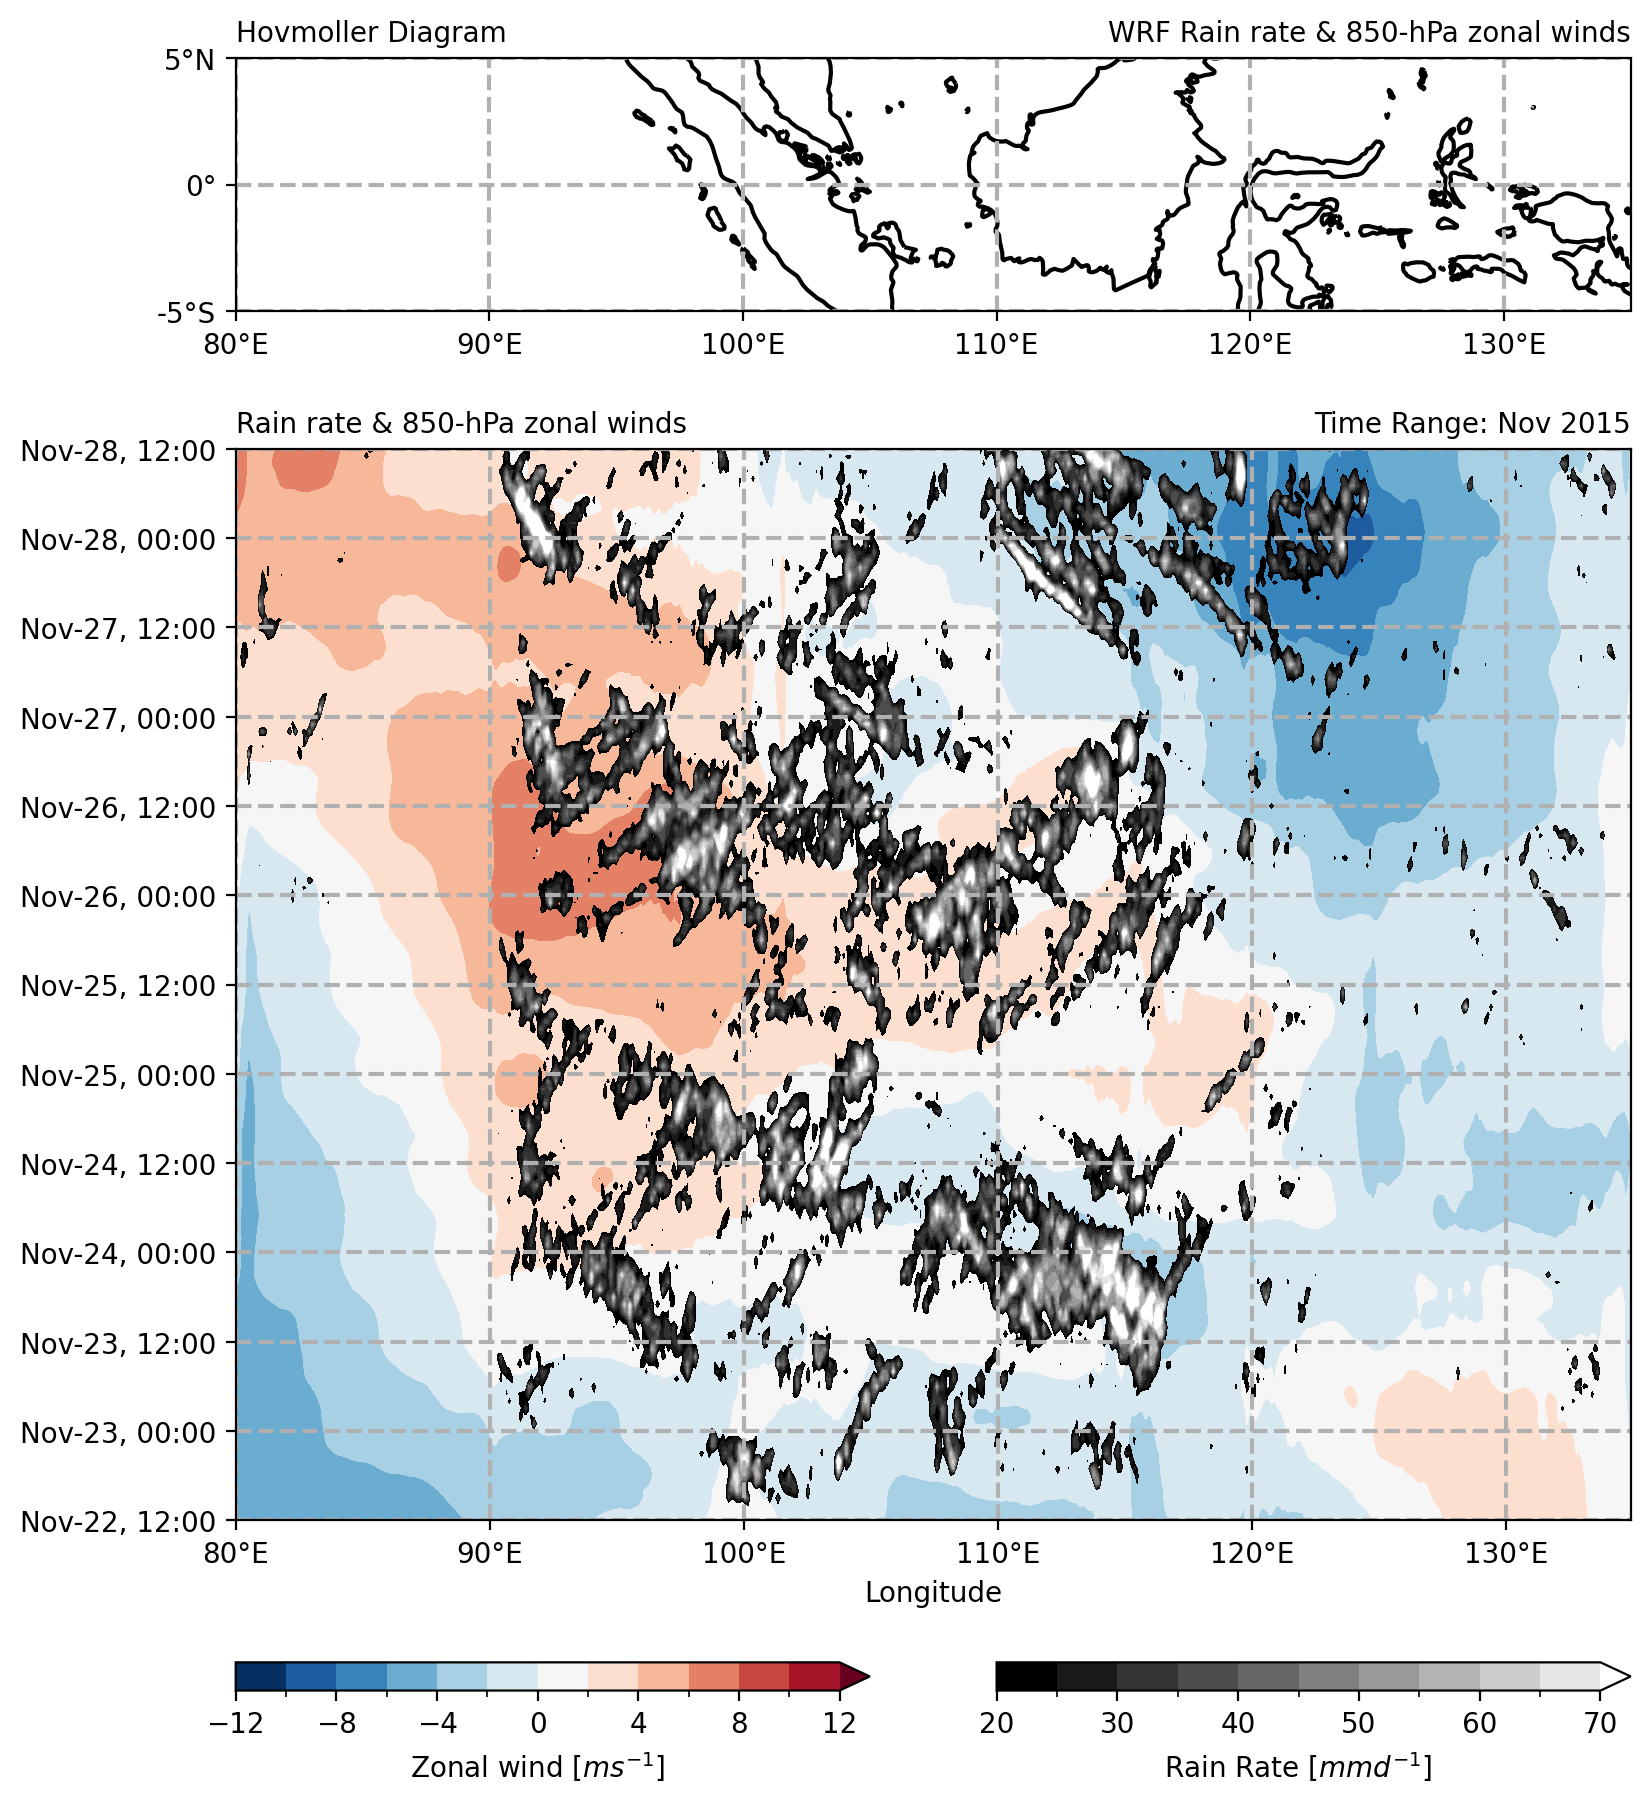

In [235]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_d01_RR.where(
    (da_d01_RR.XLAT>lat_avg_bound[0]) & (da_d01_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24
# Create a meta data point for rain rate that matches the Longitude
x1 = x1.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))
x1 = x1.set_index(Time='XTIME')

# Isolate and average the 850 hPa zonal winds between the lat_avg_bounds
x2 = da_d01_U850.where(
    (da_d01_U850.XLAT>lat_avg_bound[0]) & (da_d01_U850.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')
# Apply a rolling center mean for zonal winds to smooth it out
x2 = x2.rolling(Time=4*2, min_periods=1, center=True).mean()
x2 = x2.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))
x2 = x2.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the zonal winds
cf1 = x2.plot.contourf(
	# x = 'west_east',
    # y = 'Time',
    ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-12, vmax=12,
	extend='max'
)

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray',
	levels=np.arange(20,75,5),
	vmin=20, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### Hovmoller Diamgram D02

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(8,9))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.3,0.035,0.65,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound_d01[0]+15,lon_bound_d01[1],15))
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)



#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x = da_d02_RR.where(
    (da_d02_RR.XLAT>lat_avg_bound[0]) & (da_d02_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24
# Create a meta data point for rain rate that matches the time
x = x.assign_coords(Time=da_d02_AR.XTIME)
x = x.assign_coords(west_east=da_d02_AR.XLONG[0,0,:])

# Isolate and average the 850 hPa zonal winds between the lat_avg_bounds
y = da_d02_U850.where(
    (da_d02_U850.XLAT>lat_avg_bound[0]) & (da_d02_U850.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')
# Apply a rolling center mean for zonal winds to smooth it out
y = y.rolling(Time=4*2, min_periods=1, center=True).mean()
y = y.assign_coords(west_east=da_d02_AR.XLONG[0,0,:])

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound_d01[0]+15,lon_bound_d01[1],15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-12, vmax=12,
	extend='max'
)

# Plot the rain rates
cf2 = x.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound_d01[0]+15,lon_bound_d01[1],15),
	cmap='gray',
	levels=np.arange(20,80,5),
	vmin=20, vmax=80,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=2)
ax2.grid(linestyle='--', axis='y', linewidth=2)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 2015', loc='right', fontsize=10)
ax2.set_title('')
ax2.set_xticklabels(x_tick_labels)
t = y.Time[0::6].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(y.Time[0::6])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### Diurnal Hovmoller Diagram d01

In [177]:
def hov_diurnal(da):
    # Average over the bounds to create shape of (time,west_east)
    da_avg = da.where((da.XLAT>lat_avg_bound[0])&(da.XLAT<lat_avg_bound[1]),drop=True).mean(dim='south_north')
    # Create a np.array with shape (west_east,hour). Then populate each longitude column with its respective
        # diurnal cycle of rain rate.
    array = np.zeros((da_avg.shape[1],24))
    # Loop through each longitude, look through all the timesteps and group them by hour,
        # and then average the values at each hour. Output the 1x24 array into the empty array
    for i in range(array.shape[0]):
        array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()
    return array

Text(0, 0.5, 'Local Time')

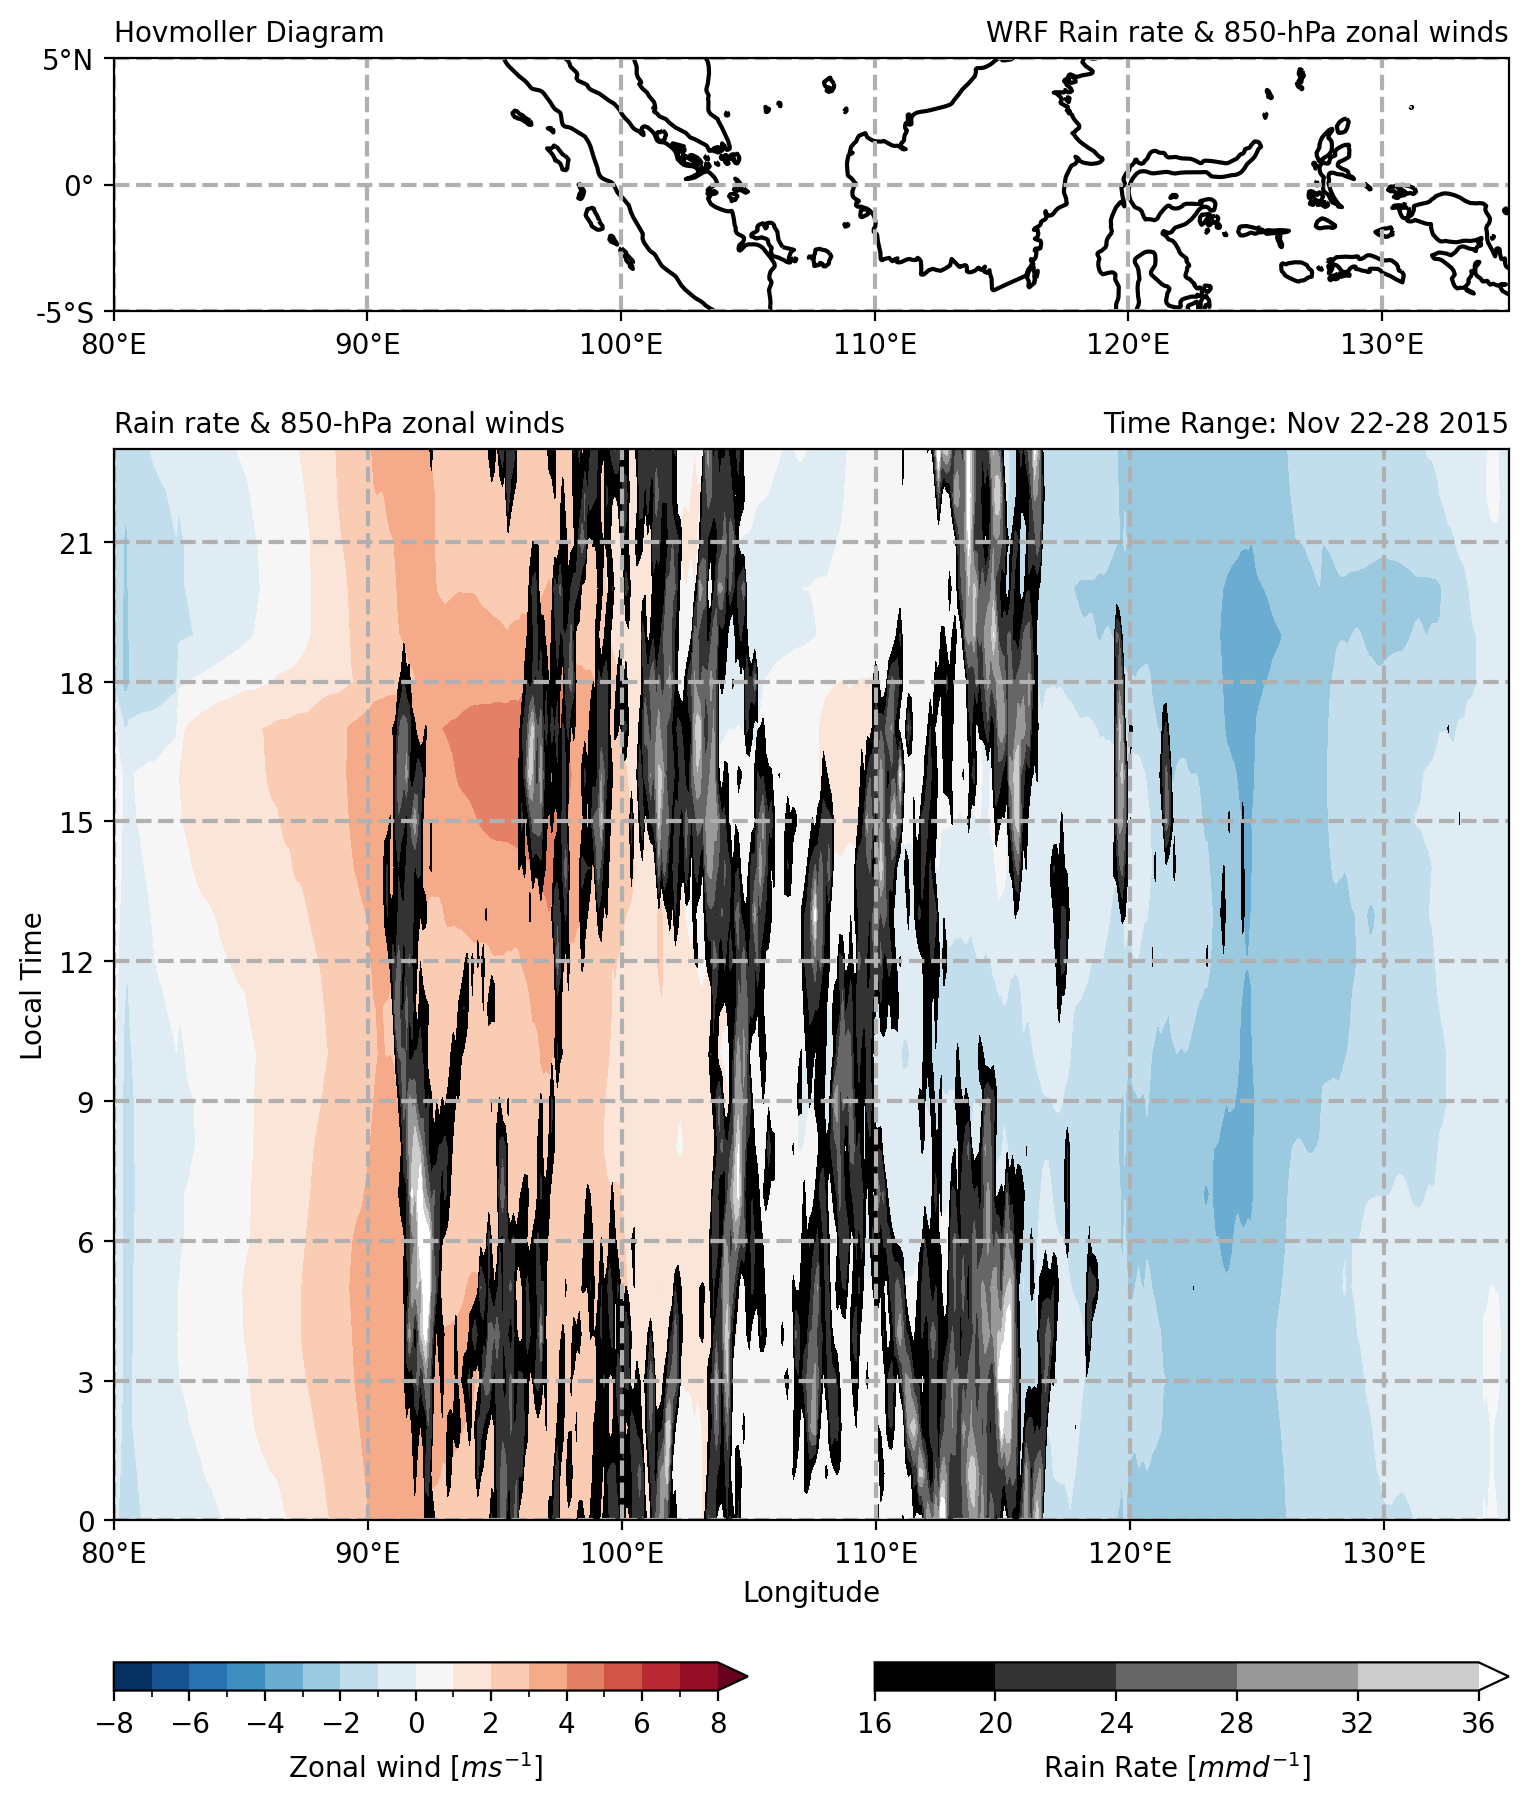

In [236]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################



# Composite over the dirunal cycle between latitudes
lat_avg_bound = [-5,5]

# Rain rate
array = hov_diurnal(da_d01_RR)
array = array*24	# Convert to mm/day
# Create the DataArray that holds the np.array you just created
x1 = xr.DataArray(
    data = array,
    dims = ['west_east','hour'],
    coords = dict(
        west_east=('west_east',da_d01_RR.XLONG[0,0,:].values),
        hour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Diurnal Rain Rate',
        units='mm/day')
)

# U-850 winds
array = hov_diurnal(da_d01_U850)
# Create the DataArray that holds the np.array you just created
y1 = xr.DataArray(
    data = array,
    dims = ['west_east','hour'],
    coords = dict(
        west_east=('west_east',da_d01_RR.XLONG[0,0,:].values),
        hour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Diurnal 850-hPa zonal winds',
        units='m/s')
)

########################################
############### PLOTTING ###############
########################################
ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y1.plot.contourf(
    x = 'west_east',
    y = 'hour',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-8,9,1),
	vmin=-8, vmax=8,
	extend='max',
)

# Plot the rain rates
cf2 = x1.plot.contourf(
    x = 'west_east',
    y = 'hour',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray',
	levels=np.arange(16,40,4),
	vmin=16, vmax=36,
	extend='max',
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22-28 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)

# t = ds_d01.XTIME[12:36:3].dt.strftime('%H:%M')
ax2.set_yticks(y1.hour[0::3])
# ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Local Time')

Text(0, 0.5, 'UTC')

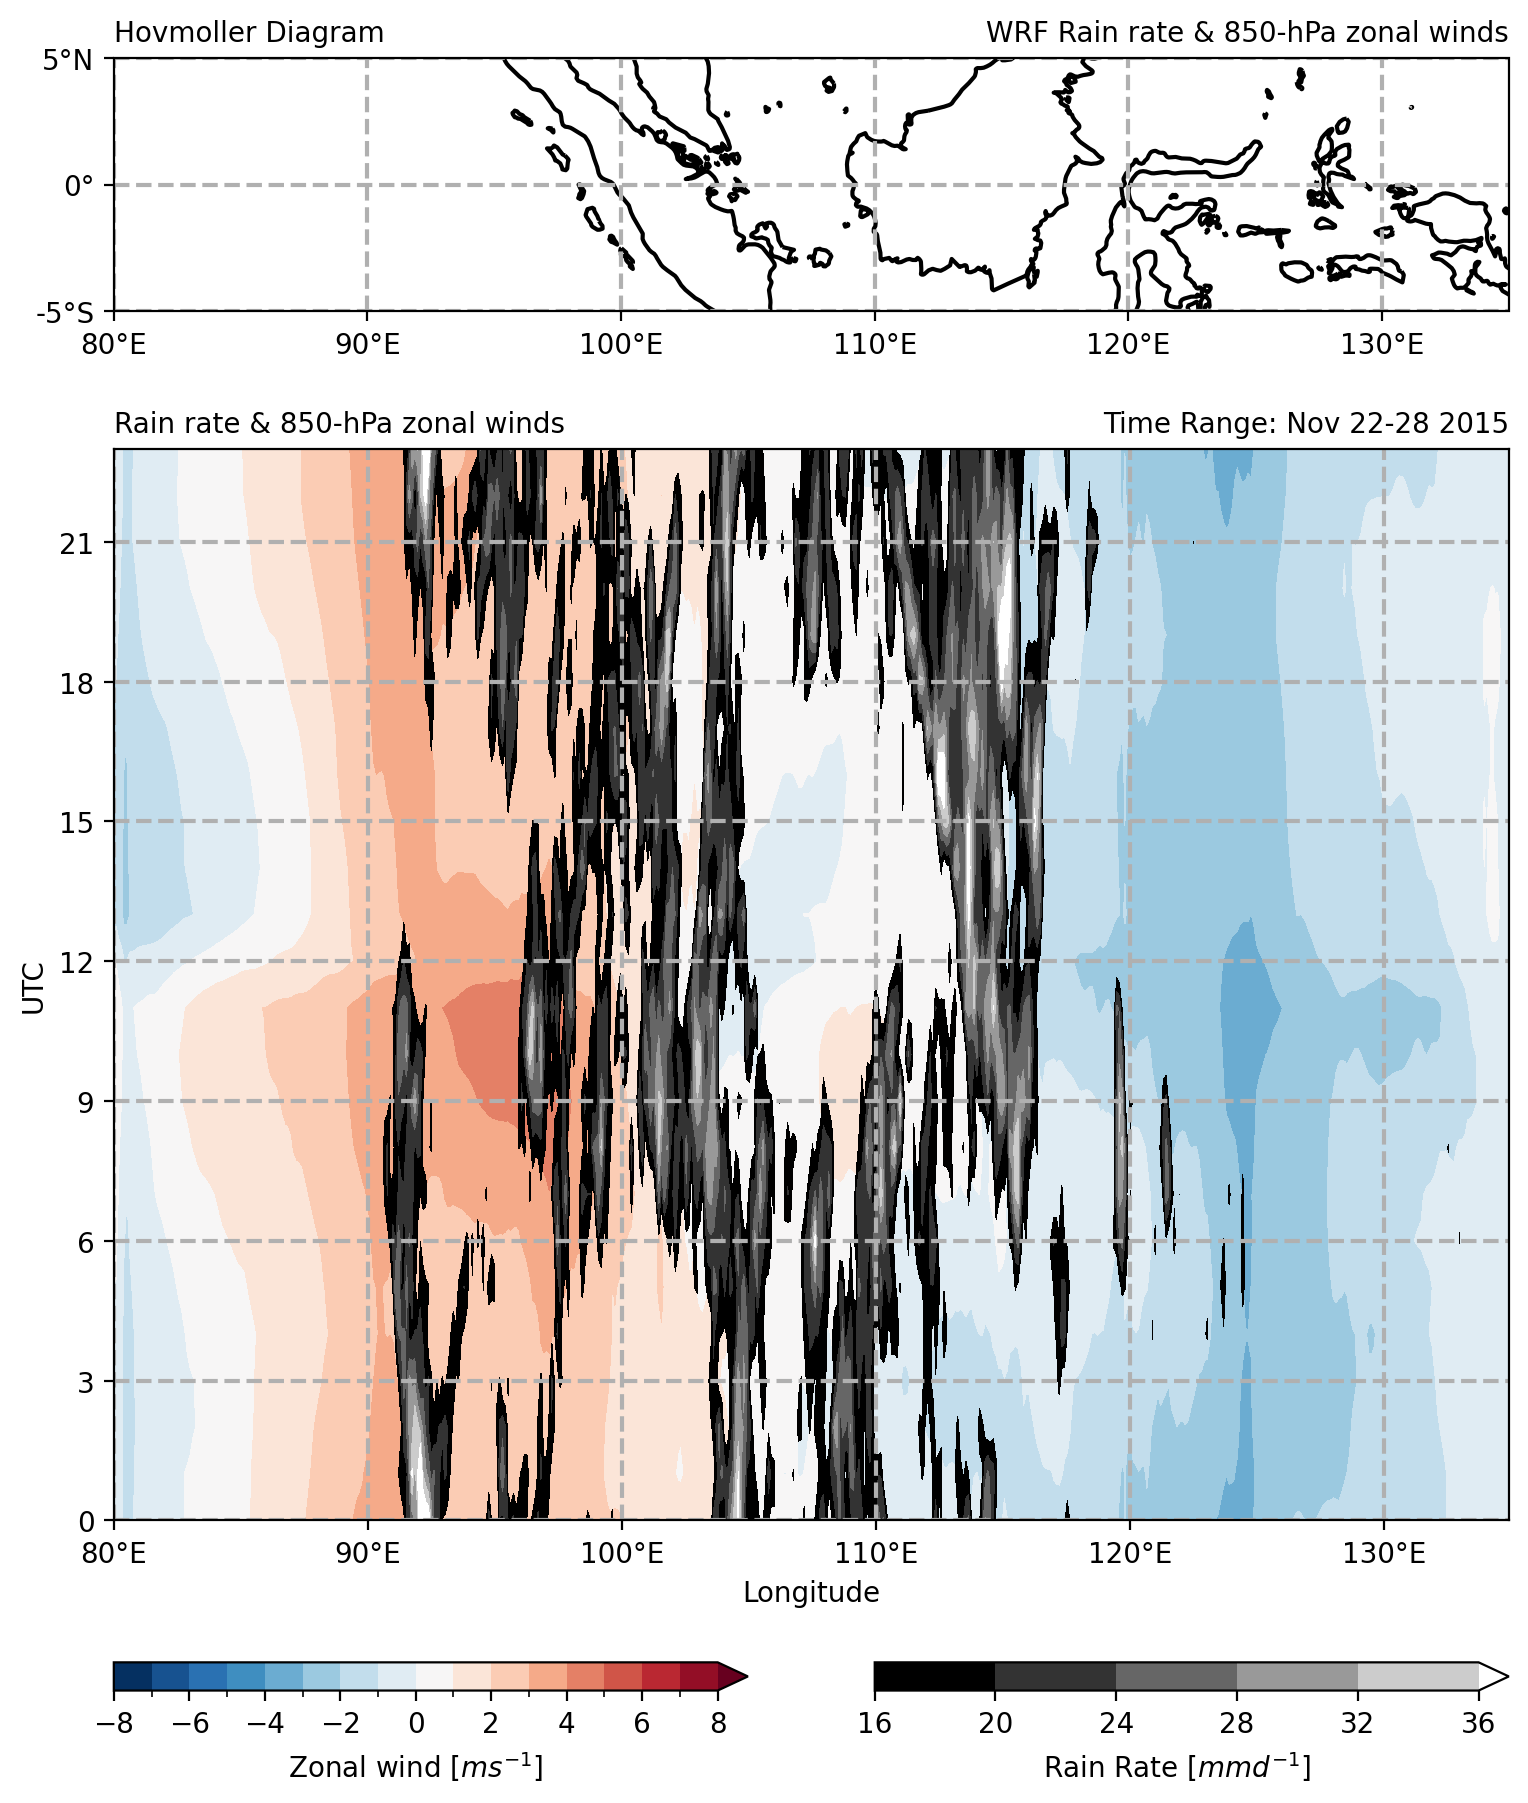

In [258]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################



# Composite over the dirunal cycle between latitudes
lat_avg_bound = [-5,5]

# Rain rate
x1 = da_d01_RR.where(
    (da_d01_RR.XLAT>lat_avg_bound[0])&(da_d01_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean(dim='south_north')*24
x1 = x1.groupby('XTIME.hour').mean()
x1 = x1.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))

# U-850 winds
y1 = da_d01_U850.where(
    (da_d01_U850.XLAT>lat_avg_bound[0]) & (da_d01_U850.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')
y1 = y1.groupby('XTIME.hour').mean()
y1 = y1.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))

########################################
############### PLOTTING ###############
########################################
ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y1.plot.contourf(
    x = 'west_east',
    y = 'hour',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-8,9,1),
	vmin=-8, vmax=8,
	extend='max',
)

# Plot the rain rates
cf2 = x1.plot.contourf(
    x = 'west_east',
    y = 'hour',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray',
	levels=np.arange(16,40,4),
	vmin=16, vmax=36,
	extend='max',
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22-28 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)

# t = ds_d01.XTIME[12:36:3].dt.strftime('%H:%M')
ax2.set_yticks(y1.hour[0::3])
# ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('UTC')

In [ ]:
# Ty suggestion
# # UTC
# t = da_d01_P.Time
# # print(t[0],t[-1])
# t = t.values
# t = pd.DatetimeIndex(t)
# b = [cftime.date2num(i,units='hours since 2015-11-24',calendar='standard') for i in t]
# b = np.array(b)
# c = b[:,None,None] + a.values[None]
# c
# d = np.zeros_like(c,dtype=object)
# d.shape

# for i in range(d.shape[1]):
# 	print(i)
# 	for j in range(d.shape[2]):
# 		d[:,i,j] = [cftime.num2date(k,units='hours since 2015-11-24',calendar='standard') for k in c[:,i,j]]
# d

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(8,8))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.3,0.035,0.5,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(lon_bound_d01[0]+15,lon_bound_d01[1],15))
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'105\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'135\N{DEGREE SIGN}E', u'150\N{DEGREE SIGN}E']
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=2)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################

# Composite over the dirunal cycle between latitudes
lat_avg_bound = [-5,5]

# Rain rate
array = hov_diurnal(da_d02_RR)
array = array*24	# Convert to mm/day
# Create the DataArray that holds the np.array you just created
x1 = xr.DataArray(
    data = array,
    dims = ['west_east','hour'],
    coords = dict(
        XLONG=('west_east',da_d02_RR.XLONG[0,0,:].values),
        LocalHour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Diurnal Rain Rate',
        units='mm/day')
)

# U-850 winds
array = hov_diurnal(da_d02_U850)
# Create the DataArray that holds the np.array you just created
y1 = xr.DataArray(
    data = array,
    dims = ['west_east','hour'],
    coords = dict(
        XLONG=('west_east',da_d02_RR.XLONG[0,0,:].values),
        LocalHour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Diurnal Rain Rate',
        units='mm/day')
)

########################################
############### PLOTTING ###############
########################################
ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()
# Plot the zonal winds
cf1 = y1.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound_d01[0]+15,lon_bound_d01[1],15),
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-12, vmax=12,
	extend='max',
    x = 'XLONG'
)

# Plot the rain rates
cf2 = x1.plot.contourf(
	ax=ax2,
	add_colorbar=False,
	xticks=np.arange(lon_bound_d01[0]+15,lon_bound_d01[1],15),
	cmap='gray',
	levels=np.arange(20,55,5),
	vmin=20, vmax=50,
	extend='max',
    x = 'XLONG'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1)
ax2.grid(linestyle='--', axis='y', linewidth=1)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')


# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 2015', loc='right', fontsize=10)
ax2.set_title('')

# ax2.set_xticks(np.arange(lon_bound_d01[0]+15,lon_bound_d01[1],15))
ax2.set_xticklabels(x_tick_labels)

t = da_d02_U850.Time[12:36:3].dt.strftime('%H:%M')
ax2.set_yticks(y1.hour[0::3])
# ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Local Time')

### Diurnal average of rain rate over Ocean and Land

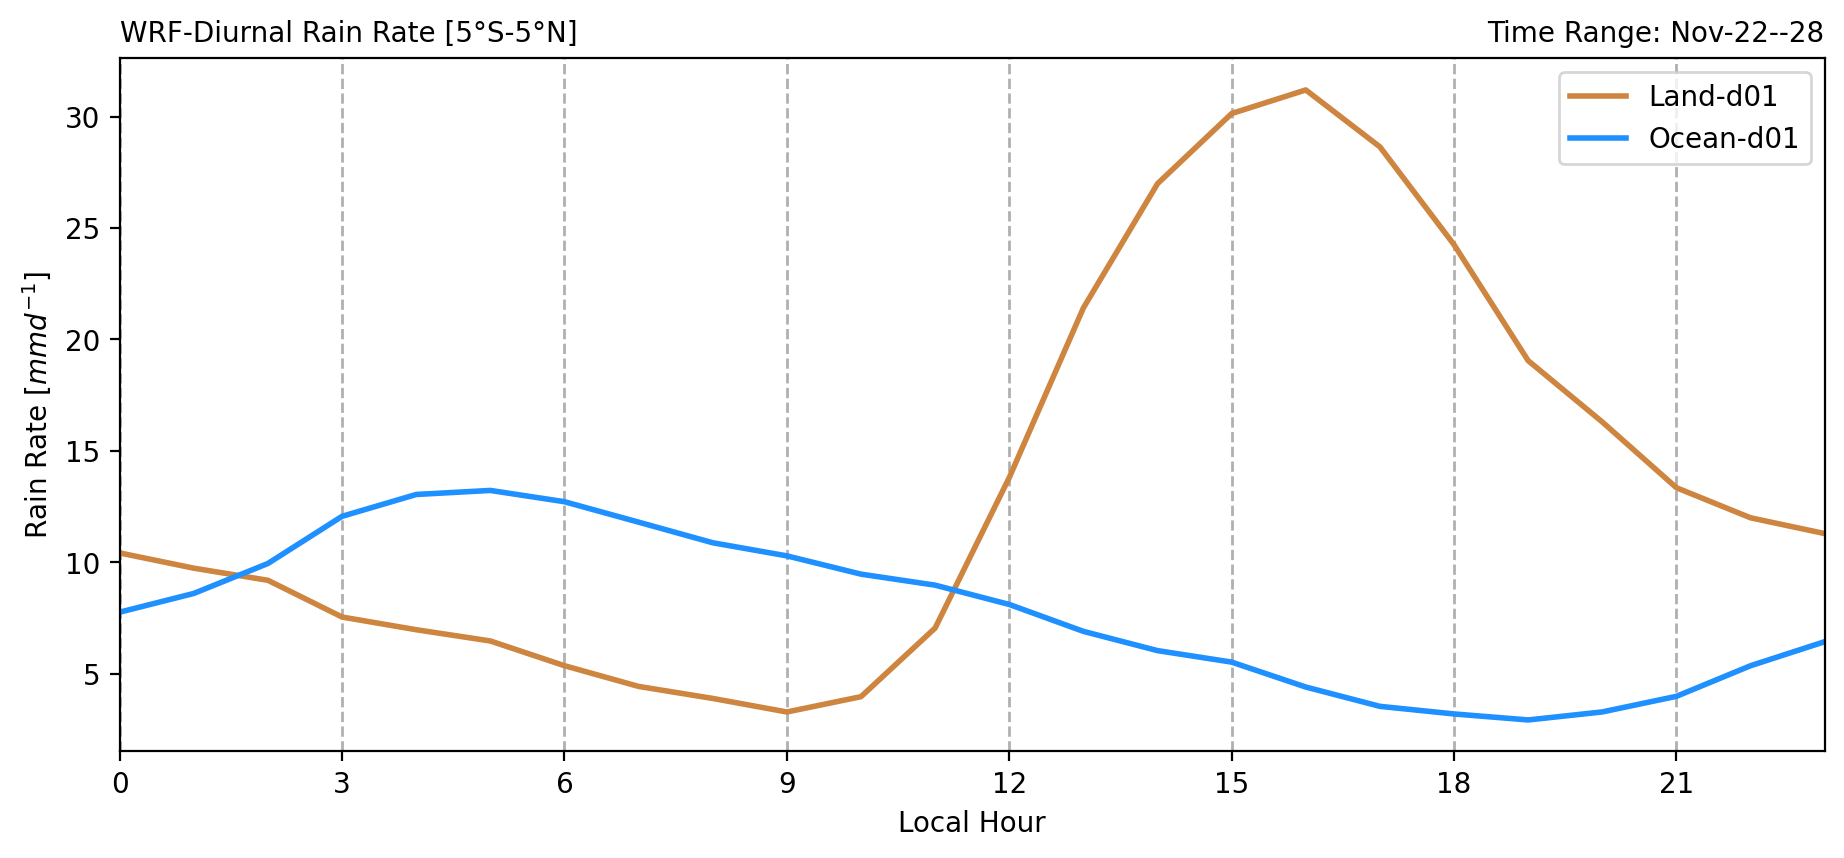

In [256]:
#################### d01 ####################

# LANDMASK (land = 1, water = 0)
########## Land ##########
da = da_d01_RR.where((da_d01_RR.XLAT>lat_bound[0])&(da_d01_RR.XLAT<lat_bound[1]),drop=False)
da_avg = da.where(da_d01_LANDMASK[0,:,:]==1,drop=False).mean(['south_north'], skipna=True)
array = np.zeros((da_avg.shape[1],24))
# Loop through each longitude, look through all the timesteps and group them by hour,
	# and then average the values at each hour. Output the 1x24 array into the empty/zero array
for i in range(array.shape[0]):
	array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()

# Create a weighted array that takes into account the number of land hits/Trues at each longitude
	# in order to weight the diurnal signal appropriately. This is to avoid weighting a longitude
    # with a few land hits with a longitude that has hundreds of hits.
# Gives the number of land hits at each longitude
w = da_d01_LANDMASK[0,:,:].where(da_d01_LANDMASK[0,:,:]==1,drop=False).sum('south_north')
w = w.values/w.values.sum()     # divide by the total land hits for a weight at each longitude
# Multiply each diurnal signal (24 hours) with the weight respective to each longitude grid
a = np.multiply(array.transpose(),w).transpose()
# Sum together normalized diurnal cycle at each longitude to get the average diurnal cycle over land
a = np.nansum(a,axis=0) * 24	# Convert to mm/day
x1 = xr.DataArray(
    data = a,
    dims = ['hour'],
    coords = dict(
        LocalHour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Average Rain Rate Diurnal Cycle over LAND',
        units='mm/day')
)

########## Ocean ##########
da = da_d01_RR.where((da_d01_RR.XLAT>lat_bound[0])&(da_d01_RR.XLAT<lat_bound[1]),drop=False)
da_avg = da.where(da_d01_LANDMASK[0,:,:]==0,drop=False).mean(['south_north'], skipna=True)
array = np.zeros((da_avg.shape[1],24))
# Loop through each longitude, look through all the timesteps and group them by hour,
	# and then average the values at each hour. Output the 1x24 array into the empty array
for i in range(array.shape[0]):
	array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()

# Create a weighting array that takes into account the number of land hits at each longitude
	# in order to weight the diurnal signal appropriately
w = da_d01_LANDMASK[0,:,:].where(da_d01_LANDMASK[0,:,:]==1,drop=False).sum('south_north')
w = w.values/w.values.sum()
# Multiply each diurnal signal (24 hours) with the weight respective to each longitude grid
a = np.multiply(array.transpose(),w).transpose()
# Sum together normalized diurnal cycle at each longitude to get the average diurnal cycle over OCEAN
a = np.nansum(a,axis=0) * 24	# Convert to mm/day
x2 = xr.DataArray(
    data = a,
    dims = ['hour'],
    coords = dict(
        LocalHour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Average Rain Rate Diurnal Cycle over OCEAN',
        units='mm/day')
)

fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

a = x1.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='peru',
    linewidth=2,
    linestyle = '-'
)
b = x2.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='dodgerblue',
    linewidth=2,
    linestyle = '-'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
# ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('WRF-Diurnal Rain Rate [5°S-5°N]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov-22--28', loc='right', fontsize=10)
ax1.set_title('')

ax1.set_xticks(np.arange(0,24,3))
# ax2.set_yticklabels(t.values)
ax1.set_xlabel('Local Hour')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(['Land-d01','Ocean-d01'])


In [255]:
lat_bound

[-5, 5]

In [ ]:

#################### d02 ####################

########## Land ##########
da = da_d02_RR.where((da_d02_RR.XLAT>lat_bound[0])&(da_d02_RR.XLAT<lat_bound[1]),drop=False)
da_avg = da.where(da_d02_LANDMASK[0,:,:]==1,drop=False).mean(['south_north'], skipna=True)
array = np.zeros((da_avg.shape[1],24))
# Loop through each longitude, look through all the timesteps and group them by hour,
	# and then average the values at each hour. Output the 1x24 array into the empty/zero array
for i in range(array.shape[0]):
	array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()

# Create a weighted array that takes into account the number of land hits/Trues at each longitude
	# in order to weight the diurnal signal appropriately. This is to avoid weighting a longitude
    # with a few land hits with a longitude that has hundreds of hits.
# Gives the number of land hits at each longitude
w = da_d02_LANDMASK[0,:,:].where(da_d02_LANDMASK[0,:,:]==1,drop=False).sum('south_north')
w = w.values/w.values.sum()     # divide by the total land hits for a weight at each longitude
# Multiply each diurnal signal (24 hours) with the weight respective to each longitude grid
a = np.multiply(array.transpose(),w).transpose()
# Sum together normalized diurnal cycle at each longitude to get the average diurnal cycle over land
a = np.nansum(a,axis=0) * 24	# Convert to mm/day
y1 = xr.DataArray(
    data = a,
    dims = ['hour'],
    coords = dict(
        LocalHour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Average Rain Rate Diurnal Cycle over LAND',
        units='mm/day')
)

########## Ocean ##########
da = da_d02_RR.where((da_d02_RR.XLAT>lat_bound[0])&(da_d02_RR.XLAT<lat_bound[1]),drop=False)
da_avg = da.where(da_d02_LANDMASK[0,:,:]==0,drop=False).mean(['south_north'], skipna=True)
array = np.zeros((da_avg.shape[1],24))
# Loop through each longitude, look through all the timesteps and group them by hour,
	# and then average the values at each hour. Output the 1x24 array into the empty array
for i in range(array.shape[0]):
	array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()

# Create a weighting array that takes into account the number of land hits at each longitude
	# in order to weight the diurnal signal appropriately
w = da_d02_LANDMASK[0,:,:].where(da_d02_LANDMASK[0,:,:]==1,drop=False).sum('south_north')
w = w.values/w.values.sum()
# Multiply each diurnal signal (24 hours) with the weight respective to each longitude grid
a = np.multiply(array.transpose(),w).transpose()
# Sum together normalized diurnal cycle at each longitude to get the average diurnal cycle over OCEAN
a = np.nansum(a,axis=0) * 24	# Convert to mm/day
y2 = xr.DataArray(
    data = a,
    dims = ['hour'],
    coords = dict(
        LocalHour=('hour',np.arange(0,24))),
    attrs=dict(
        description='Average Rain Rate Diurnal Cycle over OCEAN',
        units='mm/day')
)


ValueError: For 2D inputs, please specify either hue, x or y.

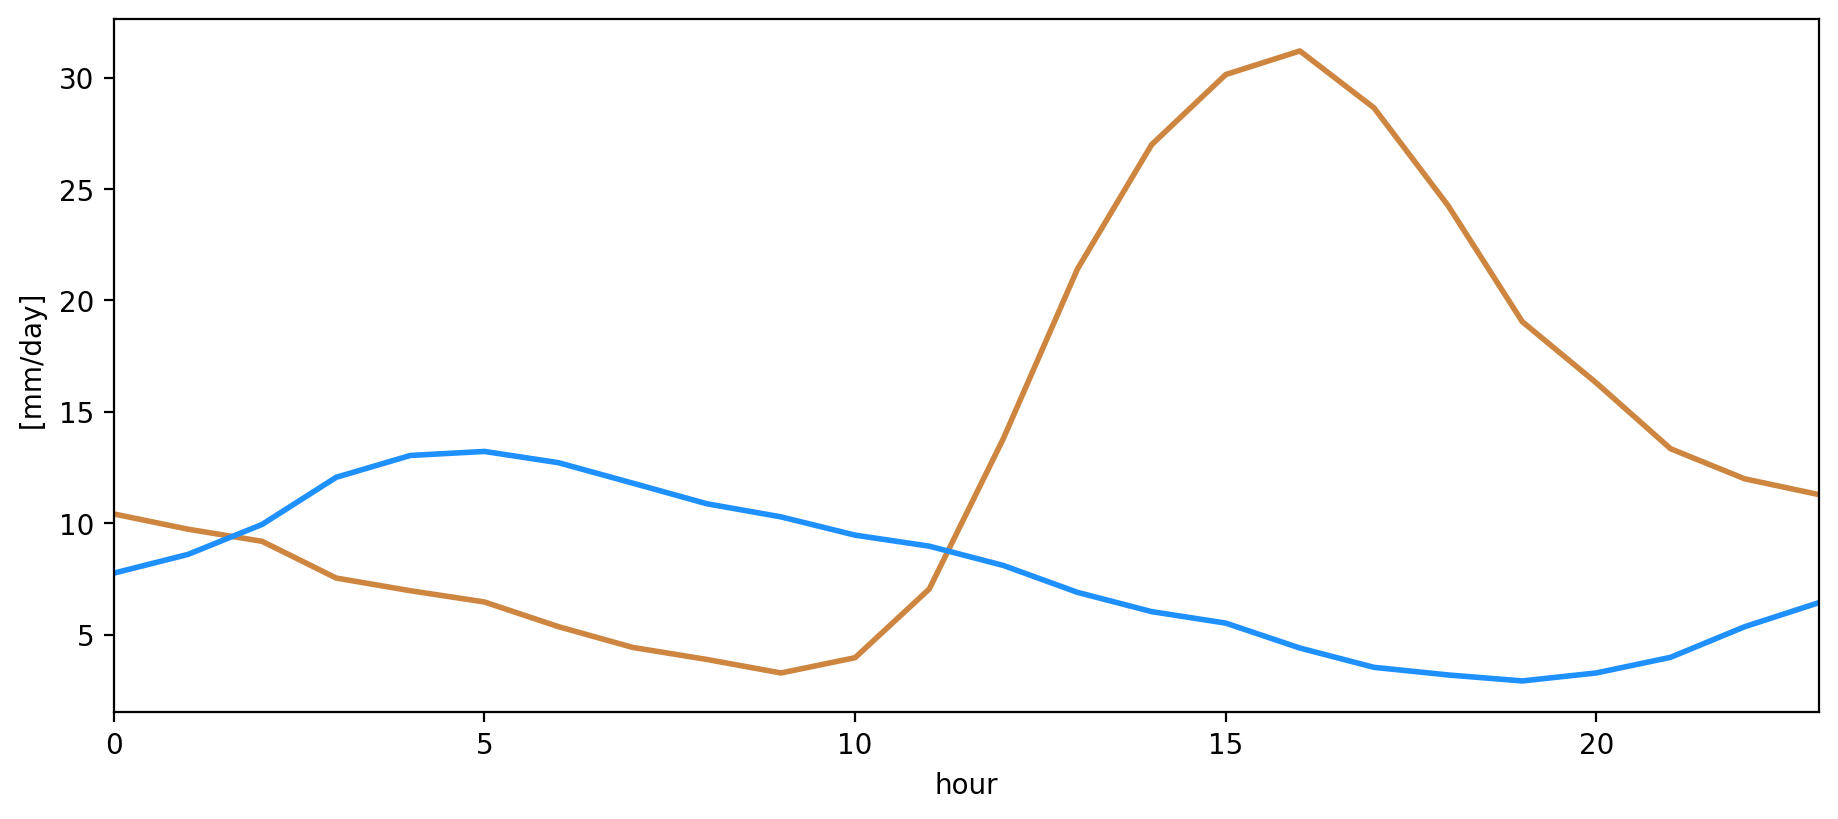

In [254]:
fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

a = x1.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='peru',
    linewidth=2,
    linestyle = '-'
)
b = x2.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='dodgerblue',
    linewidth=2,
    linestyle = '-'
)
c = y1.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='peru',
    linewidth=2,
    linestyle = '--'
)
d = y2.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='dodgerblue',
    linewidth=2,
    linestyle = '--'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
# ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('WRF-Diurnal Rain Rate [10°S-10°N]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov-24--26', loc='right', fontsize=10)
ax1.set_title('')

ax1.set_xticks(np.arange(0,24,3))
# ax2.set_yticklabels(t.values)
ax1.set_xlabel('Local Hour')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(['Land-d01','Ocean-d01','Land-d02','Ocean-d02'])
